# **Visual Turing Test**
---
De la rosa Rincón Carlos Andrés  
UASLP  
Cómputo Bio-Inspirado

In [ ]:
#Crear carpetas para hacer el set de datos y agregar las imágenes en ellas
!mkdir dataset
!mkdir dataset/Disgust
!mkdir dataset/Fear
!mkdir dataset/Happiness
!mkdir dataset/Neutral
!mkdir dataset/Sadness
!mkdir dataset/Surprise

In [ ]:
#Mostrar cuantas imágenes hay en cada categoría en el dataset
!ls /content/dataset/Disgust | wc -l
!ls /content/dataset/Fear | wc -l
!ls /content/dataset/Happiness | wc -l
!ls /content/dataset/Neutral | wc -l
!ls /content/dataset/Sadness | wc -l
!ls /content/dataset/Surprise | wc -l

100
100
100
100
100
100


Found 480 images belonging to 6 classes.
Found 119 images belonging to 6 classes.


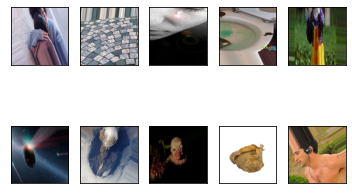

In [ ]:
#Aumento de datos con ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

#Crear el dataset generador
datagen = ImageDataGenerator(
    rescale = 1. / 255,
    rotation_range = 30,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 15,
    zoom_range = [0.5, 1.5],
    validation_split = 0.2  #20% Testing
)

#Generadores para sets de entrenamiento y pruebas
data_gen_entrenamiento = datagen.flow_from_directory('/content/dataset', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='training') 
data_gen_pruebas = datagen.flow_from_directory('/content/dataset', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='validation') 

#Imprimir 10 imagenes del generador de entrenamiento
for imagen, etiqueta in data_gen_entrenamiento:
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagen[i])
  break
plt.show()



In [ ]:
#Importar el modelo
import tensorflow as tf
import tensorflow_hub as hub

url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobilenetv2 = hub.KerasLayer(url, input_shape=(224,224,3))

In [ ]:
#Congelar el modelo descargado
mobilenetv2.trainable = False

In [ ]:
#Creación del modelo
modelo = tf.keras.Sequential([
    mobilenetv2,
    tf.keras.layers.Dense(6, activation='softmax') # Agregamos la nueva capa con 6 neuronas con activación Softmax
])

In [ ]:
#Compilar el modelo
modelo.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
#Entrenar el modelo
EPOCAS = 50

historial = modelo.fit(
    data_gen_entrenamiento, epochs=EPOCAS, batch_size=32,
    validation_data=data_gen_pruebas 
)

Epoch 1/50
 8/15 [===============>..............] - ETA: 3s - loss: 0.0901 - accuracy: 0.9648

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


15/15 [==============================] - 14s 878ms/step - loss: 0.0807 - accuracy: 0.9667 - val_loss: 1.1358 - val_accuracy: 0.6807
Epoch 2/50
15/15 [==============================] - 11s 773ms/step - loss: 0.0507 - accuracy: 0.9875 - val_loss: 1.1008 - val_accuracy: 0.6975
Epoch 3/50
15/15 [==============================] - 11s 774ms/step - loss: 0.0457 - accuracy: 0.9917 - val_loss: 1.5061 - val_accuracy: 0.6807
Epoch 4/50
15/15 [==============================] - 11s 775ms/step - loss: 0.0538 - accuracy: 0.9833 - val_loss: 1.2735 - val_accuracy: 0.7395
Epoch 5/50
15/15 [==============================] - 11s 775ms/step - loss: 0.0664 - accuracy: 0.9750 - val_loss: 1.3210 - val_accuracy: 0.6807
Epoch 6/50
15/15 [==============================] - 11s 770ms/step - loss: 0.0668 - accuracy: 0.9812 - val_loss: 1.4804 - val_accuracy: 0.6639
Epoch 7/50
15/15 [==============================] - 12s 779ms/step - loss: 0.0385 - accuracy: 0.9917 - val_loss: 1.2774 - val_accuracy: 0.7059
Epoch 8/50

In [ ]:
#Gráficas de precisión
acc = historial.history['accuracy']
val_acc = historial.history['val_accuracy']

loss = historial.history['loss']
val_loss = historial.history['val_loss']

rango_epocas = range(60)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label="Precisión Entrenamiento")
plt.plot(rango_epocas, val_acc, label="Precisión Pruebas")
plt.legend(loc='lower right')
plt.title("Precisión de entrenamiento y pruebas")

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label="Pérdida Entrenamiento")
plt.plot(rango_epocas, val_loss, label="Pérdida Pruebas")
plt.legend(loc='upper right')
plt.title("Pérdida de entrenamiento y pruebas")
plt.show()

NameError: ignored

In [ ]:
import requests
from io import BytesIO
import cv2
from PIL import Image

def categorizar(url):
    respuesta = requests.get(url)
    img = Image.open(BytesIO(respuesta.content))
    img = np.array(img).astype(float)/255

    img = cv2.resize(img, (224,224))
    prediccion = modelo.predict(img.reshape(-1, 224, 224, 3))
    return np.argmax(prediccion[0], axis = -1)

In [ ]:
#0 = Disgust,   1 = Fear,   2 = Happiness,  3 = Neutral,  4 = Sadness,  5 = Surprise 

url = ['https://i.ibb.co/gRGgRmX/Bloody-knife-1.jpg',  # Debe ser 1
      'https://i.ibb.co/dfxTrzT/Bored-pose-6.jpg',     # Debe ser 4
      'https://i.ibb.co/179797J/Cardboard-3.jpg',      # Debe ser 3
      'https://i.ibb.co/gjDmkqJ/Cockroach-4.jpg',      # Debe ser 0
      'https://i.ibb.co/WVZY8Dc/Couple-7.jpg',         # Debe ser 2 
      'https://i.ibb.co/BjWHxRJ/Fire-1.jpg']           # Debe ser 5

for i in range(6):
  prediccion = categorizar(url[i])
  print(prediccion)


2
4
3
0
4
5
